<a href="https://colab.research.google.com/github/iliya1984/DevML/blob/main/computer_vision/face_recognition/yale_dataset_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yale dataset preparation

## Loading libraries and mounting drive

In [70]:
from PIL import Image
import cv2
import numpy as np

from google.colab.patches import cv2_imshow
from google.colab import drive

import pathlib
import zipfile
import os
from os import path
import shutil
import glob

import random
import json

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
%run '/content/drive/MyDrive/Workspace/Computer Vision/cv_common.ipynb'

Common library was successfully loaded


## Loading full dataset

In [72]:
zip_file_path = f'{datasets_directory}/yale_faces/yalefaces.zip'
temp_directory = './content/datasets'
extract_path = f'{temp_directory}/yale_dataset_preparation/all'
train_set_path = f'{temp_directory}/yale_dataset_preparation/train'
test_set_path =  f'{temp_directory}/yale_dataset_preparation/test'

In [73]:
zip_object = zipfile.ZipFile(file=zip_file_path, mode = 'r')
zip_object.extractall(extract_path)
zip_object.close()

In [74]:
class ImageProperty:
  FILE_NAME_INDEX = 0
  LABEL_INDEX = 1
  IMAGE_INDEX = 2

def get_image_paths():
  image_paths = os.listdir(extract_path)
  invalid_paths = []
  for path in image_paths:
    if not ("subject" in path):
      print(f'Invalid path "{path}"')
      invalid_paths.append(path)

  for path in invalid_paths:
    image_paths.remove(path)
    print(f'Removed path "{path}"')

  return image_paths

def get_image_data():
  image_paths = get_image_paths()
  paths = [os.path.join(extract_path, f) for f in image_paths]
  #print(paths)

  faces = []
  for path in paths:
    image = Image.open(path).convert('L')
    image_np = np.array(image, 'uint8')
    label = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))
    file_path = os.path.split(path)[1]
    faces.append((file_path, label, image_np))

  return faces

In [75]:
images = get_image_data()
random.shuffle(images)
sample_image = images[0]

Invalid path "data"
Invalid path "Readme.txt"
Removed path "data"
Removed path "Readme.txt"


## Printing sample image

Image file name "subject09.surprised"
Label "9"


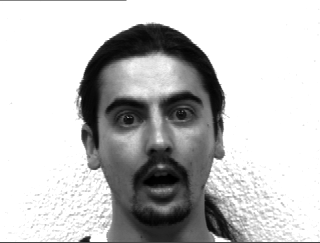

In [76]:
print(f'Image file name "{sample_image[ImageProperty.FILE_NAME_INDEX]}"')
print(f'Label "{sample_image[ImageProperty.LABEL_INDEX]}"')
cv2_imshow(sample_image[ImageProperty.IMAGE_INDEX])

## Spliting data set to train and test sets

In [77]:
dataset_size = len(images)
train_set = []
test_set = []

split_ratio = 0.75
split_threshold = int(split_ratio * dataset_size)

index = 0;
for face in images:
  if index < split_threshold:
    train_set.append(face)
  else:
    test_set.append(face)

  index = index + 1

print(f'Splited faces dataset to a train set of the size {len(train_set)} and a test set of the size {len(test_set)}')

Splited faces dataset to a train set of the size 123 and a test set of the size 42


## Storing archived splited dataset back to drive

In [80]:
def store_dataset_to_drive(dataset_name, target_file_name, working_directory, image_dataset):
  images_path = working_directory + '/images'

  #Creating working directories
  create_directory(working_directory)
  create_directory(images_path)
  clear_directory(images_path)

  #Saving images into working directory
  images_metadata = []
  index = 1
  for image_item in image_dataset:
    file_name = image_item[ImageProperty.FILE_NAME_INDEX]
    image = Image.fromarray(image_item[ImageProperty.IMAGE_INDEX], "L")
    file_path = f'{images_path}/{file_name}.jpeg'
    image.save(file_path)
    #print(f'Storing {index} - {file_name} image for {target_file_name} dataset')

    image_metadata = {}
    image_metadata['fileName'] = file_name
    image_metadata['path'] = file_path
    image_metadata['label'] = image_item[ImageProperty.LABEL_INDEX]
    images_metadata.append(image_metadata)

    index = index + 1

  #Saving metadata into working directory
  metadata = {}
  metadata['images'] = images_metadata
  print(f'Image dataset was saved to {images_path}')

  metadata_file_path = working_directory + '/metadata.json'
  with open(metadata_file_path, "w") as outfile:
    json.dump(metadata, outfile)

  #Archiving dataset into zip file
  directory = pathlib.Path(images_path)
  archived_file_path = f"{working_directory}/{target_file_name}.zip"
  with zipfile.ZipFile(archived_file_path, mode="w") as archive:
    for file_path in directory.iterdir():
      archive.write(file_path, arcname=file_path.name)

  #Copying archived dataset back to drive
  shutil.copyfile(f"{working_directory}/{target_file_name}.zip", f'{datasets_directory}/{dataset_name}/{target_file_name}.zip')
  shutil.copyfile(f"{working_directory}/metadata.json", f'{datasets_directory}/{dataset_name}/{target_file_name}_metadata.json')


In [81]:
#Storing splited archived dataset back to drive
store_dataset_to_drive('yale_faces', 'train', train_set_path, train_set)
store_dataset_to_drive('yale_faces', 'test', test_set_path, test_set)

./content/datasets/yale_dataset_preparation/train directory already exists
./content/datasets/yale_dataset_preparation/train/images directory already exists
Image dataset was saved to ./content/datasets/yale_dataset_preparation/train/images
./content/datasets/yale_dataset_preparation/test directory already exists
./content/datasets/yale_dataset_preparation/test/images directory already exists
Image dataset was saved to ./content/datasets/yale_dataset_preparation/test/images
